In [1]:
# import utilities to retrieve the dataset from Kaggle

from google.colab import files
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ikarus777/best-artworks-of-all-time --unzip

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [00:17<00:00, 159MB/s]
100% 2.29G/2.29G [00:17<00:00, 137MB/s]


In [2]:
!mkdir /content/images/images/Albrecht_Dürer/
import os
for filename in os.listdir('/content/images/images/Albrecht_DuΓòá├¬rer'):
  p = '/content/images/images/Albrecht_DuΓòá├¬rer/' + filename
  ! cp {p} '/content/images/images/Albrecht_Dürer/'
for filename in os.listdir('/content/images/images/Albrecht_Du╠êrer'):
  p = '/content/images/images/Albrecht_Du╠êrer/' + filename
  ! cp {p} '/content/images/images/Albrecht_Dürer/'

!rm -rf '/content/images/images/Albrecht_DuΓòá├¬rer'
!rm -rf '/content/images/images/Albrecht_Du╠êrer'

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
import pandas as pd
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from torchvision.io import read_image, ImageReadMode

In [2]:
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "/content/images/images"

# Number of workers for dataloader
workers = 2

# Batch size during training. Should be <= 64
batch_size = 32

image_size = 64
nz = 100
num_epochs = 60

lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu = 1

Random Seed:  999


In [3]:
def get_dataloader(batch_size, image_size, data_dir=dataroot, num_workers=3):
    target_old_to_new = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 1, 6: 5, 7: 1, 8: 6, 9: 5, 10: 1, 11: 7, 12: 8, 13: 9, 14: 10, 15: 10, 16: 11, 17: 12, 18: 13, 19: 8, 20: 7, 21: 1, 22: 11, 23: 12, 24: 0, 25: 14, 26: 0, 27: 15, 28: 16, 29: 17, 30: 11, 31: 17, 32: 8, 33: 18, 34: 12, 35: 8, 36: 2, 37: 5, 38: 1, 39: 19, 40: 0, 41: 17, 42: 5, 43: 15, 44: 15, 45: 20, 46: 17, 47: 2, 48: 12, 49: 10}

    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        # We tranform our image values to be between -1 and 1 (the range of the tanh activation)
        transforms.Normalize(*stats), # 
    ])
    target_transform = transforms.Lambda(lambda y: target_old_to_new[y])
    
    dataset = datasets.ImageFolder(root=data_dir, transform=transform, target_transform=target_transform)
    
    df = pd.read_csv("/content/artists.csv")

    artist_to_genre = {}
    for artist in dataset.classes:
        if df[df['name'] == artist.replace('_', ' ')].genre.values[0].find(',') != -1:
            val = df[df['name'] == artist.replace('_', ' ')].genre.values[0].split(',')[0]
        else:
            val = df[df['name'] == artist.replace('_', ' ')].genre.values[0]
        artist_to_genre[artist] = val

    genre_dict = {}
    new_classes = []
    idx = 0
    for artist, genre in artist_to_genre.items():
        if genre not in genre_dict:
            genre_dict[genre] = idx
            new_classes.append(genre)
            idx += 1

    dataset.classes = new_classes
    dataset.class_to_idx = genre_dict

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    print("Classes are : ", dataset.classes)
    print("Number of classes : ", len(dataset.classes))
    print("Number of images : ", len(dataset))

    return data_loader, dataset.class_to_idx

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Running on", device)

Running on cuda:0


Classes are :  ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance']
Number of classes :  21
Number of images :  8774


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


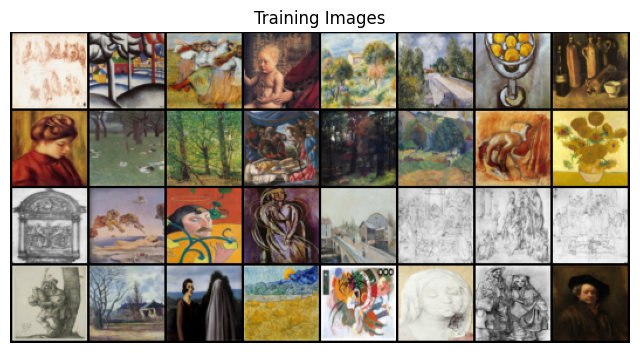

In [4]:
dataloader, classes = get_dataloader(batch_size, image_size, dataroot)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=nz, image_size=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, image_size, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(image_size, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_size=64):
        super(Discriminator, self).__init__()

        self.image_size = image_size

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

In [7]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [8]:
# Create the generator
gen = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
gen.apply(weights_init_normal)

# Print the model
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
# Create the generator
disc = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
disc.apply(weights_init_normal)

# Print the model
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader, 0):
      # print("i", i)
      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      disc.zero_grad()
      # Format batch
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      # Forward pass real batch through D
      output = disc(real_cpu).view(-1)
      # Calculate loss on all-real batch
      errD_real = criterion(output, label)
      # Calculate gradients for D in backward pass
      errD_real.backward()
      D_x = output.mean().item()

      ## Train with all-fake batch
      # Generate batch of latent vectors
      noise = torch.randn(b_size, nz, 1, 1, device=device)
      # Generate fake image batch with G
      fake = gen(noise)
      label.fill_(fake_label)
      # Classify all fake batch with D
      output = disc(fake.detach()).view(-1)
      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(output, label)
      # Calculate the gradients for this batch, accumulated (summed) with previous gradients
      errD_fake.backward()
      D_G_z1 = output.mean().item()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      gen.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = disc(fake).view(-1)
      # Calculate G's loss based on this output
      errG = criterion(output, label)
      # Calculate gradients for G
      errG.backward()
      D_G_z2 = output.mean().item()
      # Update G
      optimizerG.step()

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      

      # Check how the generator is doing by saving G's output on fixed_noise
      if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
          with torch.no_grad():
              fake = gen(fixed_noise).detach().cpu()
          img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1
      
  # Output training stats
  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
Epoch: 0
[0/70]	Loss_D: 0.0298	Loss_G: 4.9744	D(x): 0.9856	D(G(z)): 0.0151 / 0.0078
Epoch: 1
[1/70]	Loss_D: 0.4614	Loss_G: 3.0107	D(x): 0.7671	D(G(z)): 0.1495 / 0.0569
Epoch: 2
[2/70]	Loss_D: 0.9030	Loss_G: 3.6391	D(x): 0.8848	D(G(z)): 0.5124 / 0.0311
Epoch: 3
[3/70]	Loss_D: 0.4486	Loss_G: 2.6993	D(x): 0.8641	D(G(z)): 0.2577 / 0.0736
Epoch: 4
[4/70]	Loss_D: 1.1771	Loss_G: 1.4320	D(x): 0.4457	D(G(z)): 0.1480 / 0.2740
Epoch: 5
[5/70]	Loss_D: 0.4567	Loss_G: 3.5142	D(x): 0.8738	D(G(z)): 0.2523 / 0.0317
Epoch: 6
[6/70]	Loss_D: 1.8835	Loss_G: 2.3390	D(x): 0.4342	D(G(z)): 0.6140 / 0.1031
Epoch: 7
[7/70]	Loss_D: 0.8298	Loss_G: 1.3421	D(x): 0.5145	D(G(z)): 0.0533 / 0.2713
Epoch: 8
[8/70]	Loss_D: 1.0912	Loss_G: 6.6191	D(x): 0.9187	D(G(z)): 0.5461 / 0.0017
Epoch: 9
[9/70]	Loss_D: 0.9019	Loss_G: 2.3954	D(x): 0.5821	D(G(z)): 0.2340 / 0.0974
Epoch: 10
[10/70]	Loss_D: 2.6170	Loss_G: 6.4645	D(x): 0.9691	D(G(z)): 0.9164 / 0.0020
Epoch: 11
[11/70]	Loss_D: 0.3080	Loss_G: 2.0744	

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000, blit=True)

In [ ]:
ani.save('gudgan.gif', writer = "martinoux", fps=12)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

In [ ]:
def save_model(gen, disc, file_name):
    gen = gen.to('cpu')
    torch.save(gen.state_dict(),"gen_epoch_" + str(num_epochs) + ".pth")
    disc = disc.to('cpu')
    torch.save(disc.state_dict(),"disc_epoch_" + str(num_epochs) + ".pth")

save_model(gen, disc, "gudGan")